In [1]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt

%matplotlib inline

from urllib.request import urlopen
from pathlib import Path
from collections import defaultdict
from random import choice

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


## Carga de datos

In [2]:
red_lit = nx.read_edgelist('./Material_de_interes/tc02Data/yeast_LIT.txt')
red_apms = nx.read_edgelist('./Material_de_interes/tc02Data/yeast_AP-MS.txt')
red_bin = nx.read_edgelist('./Material_de_interes/tc02Data/yeast_Y2H.txt')

In [3]:
escenciales = open('./Datos/Essential_ORFs_paperHe2.txt')
lista_escenciales = []

for line in escenciales:
    lista_escenciales.append(line.rstrip('\n'))
    

In [4]:
def nodos_esenciales(red, lista_atr = lista_escenciales, atributo = 'Esencial'):
    
    dict_vacio = dict()
    nx.set_node_attributes(red, dict_vacio.fromkeys(list(red.nodes()),0), atributo )
    
    for nodo in lista_atr:
        try:
            red.nodes[nodo][atributo] = 1
        except KeyError:
            continue
            
    return None

In [5]:
nodos_esenciales(red_lit)
nodos_esenciales(red_bin)
nodos_esenciales(red_apms)

In [6]:
red_df = pd.read_csv('./Material_de_interes/tc02Data/yeast_LIT_Reguly.txt',sep="\t", header=0)

In [7]:
red_df.head()

,Bait gene/protein,Hit gene/protein,Bait Standard Name,Hit Standard Name,Experimental System,Source,PubMed ID
0,YBR236C,YML010W,ABD1,SPT5,Affinity Capture-MS,Lindstrom DL et al,12556496
1,YML010W,YBR236C,SPT5,ABD1,Affinity Capture-MS,Lindstrom DL et al,12556496
2,YDR448W,YPL254W,ADA2,HFI1,Affinity Capture-MS,Rodriguez-Navarro S et al,14718168
3,YDR448W,YDR176W,ADA2,NGG1,Affinity Capture-MS,Rodriguez-Navarro S et al,14718168
4,YDR448W,YOR257W,ADA2,CDC31,Affinity Capture-MS,Rodriguez-Navarro S et al,14718168


## B) Características de las redes

#### Tabla 1

In [8]:
import herramientas_redes as hr

In [9]:
redes = [red_apms, red_bin, red_lit]
props = []

for red in redes:
    props.append(hr.propiedades(red))
sRed = ['Red AP-MS','Red Y2H', 'Red Literatura']

In [10]:
pd.DataFrame(props, index=sRed).drop(['Densidad', 'Diámetro', 'Grado max', 'Grado min', 'Transitividad'], axis = 1)

,Clustering medio,Enlaces,Grado promedio,Nodos
Red AP-MS,0.554636,9070,11.183724,1622
Red Y2H,0.046194,2930,2.903865,2018
Red Literatura,0.292492,2925,3.808594,1536


#### Tabla 2

In [11]:
def overlap_enlaces(red1, red2):
    
    nodos = set(list(red1.nodes())+list(red2.nodes()))
    counter = 0
    for nodo in nodos:
        try:
            l1 = list(red1[nodo])
            l2 = list(red2[nodo])
            if l1 and l2:
                counter += len(hr.intersect(l1,l2))
        except KeyError:
            continue
    cantidad = counter/2
    
    return [ cantidad/ red1.number_of_edges(), cantidad/ red2.number_of_edges()]

In [12]:
lista_apms_lit = overlap_enlaces(red_apms, red_lit)
lista_lit_y2h = overlap_enlaces(red_lit,red_bin)
lista_y2h_apms = overlap_enlaces(red_bin,red_apms)

In [13]:
tabla = pd.DataFrame(np.nan, columns = sRed, index = sRed)
tabla.loc['Red AP-MS']['Red Y2H'] = lista_y2h_apms[1]
tabla.loc['Red Y2H']['Red AP-MS'] = lista_y2h_apms[0]
tabla.loc['Red AP-MS']['Red Literatura'] = lista_apms_lit[0]
tabla.loc['Red Literatura']['Red AP-MS'] = lista_apms_lit[1]
tabla.loc['Red Literatura']['Red Y2H'] = lista_lit_y2h[0]
tabla.loc['Red Y2H']['Red Literatura'] = lista_lit_y2h[1]
tabla.loc['Red Y2H']['Red Y2H'] = 1 #'Red Y2H'
tabla.loc['Red Literatura']['Red Literatura'] = 1 #'Red Literatura'
tabla.loc['Red AP-MS']['Red AP-MS'] = 1 #'Red AP-MS'

In [14]:
tabla

,Red AP-MS,Red Y2H,Red Literatura
Red AP-MS,1.000000,0.028666,0.143109
Red Y2H,0.088737,1.000000,0.087201
Red Literatura,0.443761,0.087350,1.000000


#### Tabla 3

In [58]:
redes = [red_lit, red_apms, red_bin]
grados = [dict(),dict(),dict()]
x = [list,list,list]
y = [list,list,list]

for i in range(3):
    # Set ordenado de mayor a menor de los grados.
    degs = sorted(set(dict(redes[i].degree()).values()), reverse=True)
#     print(degs)
    # Diccionario con la data de los nodos, de donde se saca si son esenciales o no.
    esc = dict(redes[i].nodes(data=True))
#     print(esc)
    #nodos_grado = defaultdict(list)
    # Diccionario donde las keys son los grados y los values son dos números. El primero
    # está relacionado con la cantidad de nodos por grado, el segundo con la cantidad
    # de esenciales por grado.
    grados[i] = {d: [0,0] for d in degs}
    for nodo, deg in redes[i].degree():
        grados[i][deg][0] += 1
        # Suma uno si el nodo es esencial.
        grados[i][deg][1] += esc[nodo]['Esencial']
        #nodos_grado[deg].append(nodo)
#     print(grados)    

In [69]:
# Ahora cambia la lista de [nodos, esenciales] por [% de nodos, %esenciales], y va acumulando.
for i in range(3):
    n = redes[i].number_of_nodes()
    acumNodos = 0
    acumEsc = 0
    df = pd.DataFrame(grados[i]).T
    df.sort_index(axis=0, ascending=False, inplace=True)
    df.columns=['nodos','esenciales']
    for row in df.iterrows():
        acumNodos += row[1]['nodos']
        acumEsc += row[1]['esenciales']
        grados[i][row[0]][1] = acumEsc / acumNodos
        grados[i][row[0]][0] = acumNodos / n
    x[i],y[i] = zip(*list(grados[i].values()))

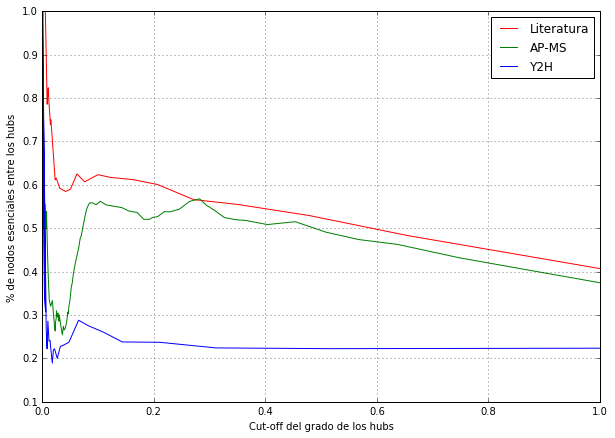

In [70]:
plt.figure(figsize=(10,7))
plt.plot(x[0],y[0],'r-', label='Literatura')
plt.plot(x[1],y[1],'g-', label='AP-MS')
plt.plot(x[2],y[2],'b-', label='Y2H')
plt.title('')
plt.xlabel('Cut-off del grado de los hubs')
plt.ylabel('% de nodos esenciales entre los hubs')
plt.legend()
plt.grid(True)

## C) Vulnerabilidad

In [17]:
def no_esenciales(red, esenciales = lista_escenciales):
    red_aux = red.copy()
    red_aux.remove_nodes_from(esenciales)
    return list(red_aux.nodes())

In [18]:
lista_no_esenciales = no_esenciales(red)

In [19]:
red = red_apms
  
medidas_centr = [lambda x: nx.degree_centrality(x), 
                 lambda x: nx.eigenvector_centrality(x, tol = 200),
                 lambda x: nx.betweenness_centrality(x),
                 lambda x: nx.current_flow_betweenness_centrality(x),
                 lambda x: nx.subgraph_centrality(x),
                 'Random']
nombres_med = ['Degree Centrality','eigen','betweenness', 'current flow', 'subgraph', 'random']

fracciones = defaultdict()

In [20]:
for medida, nombre in zip(medidas_centr,nombres_med):
    GC = max(nx.connected_component_subgraphs(red), key=len)
    n = GC.number_of_nodes()
    fraccion = []
    i=0
    print(nombre)
    if medida == 'Random':
        while i<100:

            
            lista_no_esenciales = no_esenciales(GC)
            nodo = choice(lista_no_esenciales)
            GC.remove_node(nodo)
            GC = max(nx.connected_component_subgraphs(GC), key=len)
            fraccion.append(GC.number_of_nodes()/n)
            i+=1
        
        fracciones[nombre] = fraccion
        
    else:
        while i<100:
            try:
                
                centralidad = sorted(medida(GC).items(), key = lambda x: x[1])
                GC.remove_node(centralidad[-1:][0][0])
                GC = max(nx.connected_component_subgraphs(GC), key=len)
                fraccion.append(GC.number_of_nodes()/n)
                i+=1
            
            except ZeroDivisionError:
                print(medida(GC))    
                
        fracciones[nombre] = fraccion

Degree Centrality
eigen
betweenness
current flow
subgraph
random


In [21]:
for f in 

defaultdict(None,
            {'Degree Centrality': [0.999003984063745,
              0.99800796812749,
              0.9970119521912351,
              0.9960159362549801,
              0.9950199203187251,
              0.9940239043824701,
              0.9930278884462151,
              0.9920318725099602,
              0.9910358565737052,
              0.9900398406374502,
              0.9890438247011952,
              0.9880478087649402,
              0.9860557768924303,
              0.9820717131474104,
              0.9810756972111554,
              0.9741035856573705,
              0.9731075697211156,
              0.9721115537848606,
              0.9711155378486056,
              0.9701195219123506,
              0.9691235059760956,
              0.9671314741035857,
              0.9631474103585658,
              0.9621513944223108,
              0.9601593625498008,
              0.9581673306772909,
              0.9561752988047809,
              0.9551792828685259,
            

In [ ]:
plt.figure(figsize=(10,7))
for i in fracciones
plt.plot(fracciones,y[0],'r-', label='Literatura')
plt.plot(x[1],y[1],'g-', label='AP-MS')
plt.plot(x[2],y[2],'b-', label='Y2H')
plt.title('')
plt.xlabel('Cut-off del grado de los hubs')
plt.ylabel('% de nodos esenciales entre los hubs')
plt.legend()
plt.grid(True)